In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization,Activation,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
import matplotlib.pyplot as plt
import cv2
from keras.applications.densenet import DenseNet201,preprocess_input
#from keras.applications.nasnet import NASNetLarge,preprocess_input

In [2]:
# set random seed

# Set a seed value
seed_value= 1680

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value) # for later versions
# tf.random.set_seed(seed_value) # for old versions:

# 5. For layers that introduce randomness like dropout, make sure to set seed values 
# model.add(Dropout(0.25, seed=seed_value))

#6 Configure a new global `tensorflow` session
from keras import backend as K
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
# for old versions:
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

In [3]:
# Get path to all TRAIN & TEST files
#print("glob walk file")
train_paths = glob.glob('../input/AOI/train_images/*/*')
test_paths = glob.glob('../input/AOI/test_images/*/*')

print("No. Files in Train: {:,} pictures".format(len(train_paths)), "\n" +
      "No. Files in Test: {:,} pictures".format(len(test_paths)), "\n")

No. Files in Train: 2,528 pictures 
No. Files in Test: 10,142 pictures 



In [4]:
# label data
traindf = pd.read_csv('../input/AOI/train.csv',dtype=str)
testdf = pd.read_csv('../input/AOI/test.csv',dtype=str)
print("train.csv:\n",traindf.head())
print("\n\ntest.csv:\n",testdf.head())

train.csv:
                 ID Label
0  train_00000.png     0
1  train_00001.png     1
2  train_00002.png     1
3  train_00003.png     5
4  train_00004.png     5


test.csv:
                ID Label
0  test_00000.png   NaN
1  test_00001.png   NaN
2  test_00002.png   NaN
3  test_00003.png   NaN
4  test_00004.png   NaN


In [5]:
img_ex = cv2.imread('../input/AOI/train_images/train_images/train_00000.png')
print(img_ex.shape) #dim
#cv2.imshow('test', img_ex)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

(512, 512, 3)


In [6]:
# Hyperparamters 超參數則是則是由人為給定，例如神經網路的層數、損失函數、卷積核的大小、學習率等等
resize = 128
batchsize = 32

# Data
train_gen = ImageDataGenerator(  #deal with picture(data argmentation)
    rescale=1./255.,
    #zca_whitening=True, # zca白化的作用是針對圖片進行PCA降維操作，減少圖片的冗餘信息，保留最重要的特徵
    #rotation_range=40,# Degree range for random rotations # 指定旋轉角度範圍,在 [0, 指定角度] 範圍內進行隨機角度旋轉
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2, # 線性變換推移 #讓所有點的x坐標(或者y坐標)保持不變，而對應的y坐標(或者x坐標)則按比例發生平移，且平移的大小和該點到x軸(或y軸)的垂直距離成正比
    #zoom_range=0.2, # 可以讓圖片在長或寬的方向進行放大
    horizontal_flip=True, # 水平翻轉
    vertical_flip=True, # 上下翻轉
    fill_mode='nearest', # 填充模式，當對圖片進行平移、放縮、錯切等操作時，圖片中會出現一些缺失的地方，設定這些缺失的地方該用什麼方式補全
    validation_split=0.2,  # set validation split
)
# training data
#train_data = train_gen.flow_from_directory(
train_data = train_gen.flow_from_dataframe(
    dataframe = traindf,
    directory = "../input/AOI/train_images/train_images",# 目標目錄
    x_col="ID",
    y_col="Label",
    target_size=(resize, resize), # picture change to resize x resize
    color_mode="rgb",
    #color_mode="grayscale",
    class_mode="categorical",
    #class_mode="binary",
    batch_size = batchsize,
    shuffle=True, # 是否隨機播放數據
    seed=seed_value,
    #save_format="png",
    follow_links=False,
    subset="training", # set as training data
    interpolation="nearest",
)
# validation data
#valid_data = train_gen.flow_from_directory(
valid_data = train_gen.flow_from_dataframe(
    dataframe = traindf,
    directory = "../input/AOI/train_images/train_images",# 目標目錄 # same directory as training data
    x_col="ID",
    y_col="Label",
    target_size=(resize, resize), # 所有影像調整為 resize x resize
    color_mode="rgb",
    #color_mode="grayscale",
    class_mode="categorical",
    batch_size = batchsize,
    shuffle=True, # 是否隨機播放數據
    seed=seed_value,
    #save_format="png",
    follow_links=False,
    subset="validation", # set as validation data
    interpolation="nearest",
)
# test data
test_gen = ImageDataGenerator(rescale=1./255.)
#test_data = test_gen.flow_from_directory(
test_data = test_gen.flow_from_dataframe(
    dataframe = testdf,
    directory = "../input/AOI/test_images/test_images",# 目標目錄
    x_col="ID",
    target_size=(resize, resize), # 所有影像調整為 resize x resize
    color_mode="rgb",
    #color_mode="grayscale",
    class_mode=None, # important!!!
    #class_mode="categorical",
    #class_mode="binary",
    batch_size = batchsize,
    shuffle=False, # 是否隨機播放數據
    seed=seed_value,
    #save_format="png",
    follow_links=False,
    subset=None,
    interpolation="nearest",
)

Found 2023 validated image filenames belonging to 6 classes.
Found 505 validated image filenames belonging to 6 classes.
Found 10142 validated image filenames.


In [7]:
# Reweight data class

from collections import Counter
counter = Counter(train_data.classes)
print(counter)
max_val = float(max(counter.values())) 
class_weights_dic = {class_id : max_val/num_images for class_id, num_images in counter.items()} 
#print(class_weights_dic)

sorted_items = sorted(class_weights_dic.items()) # Get key-value pairs and Sort dictionary by key
class_weights_dict = {class_id : weight for class_id, weight in sorted_items}
print(class_weights_dict)

# from collections import OrderedDict
# class_weights_dict = OrderedDict(sorted(class_weights_dic.items()))
# print(class_weights_dict)
        
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
#weight_for_0 = (1 / neg)*(total)/2.0 
#weight_for_1 = (1 / pos)*(total)/2.0
#class_weight_dic = {0: weight_for_0, 1: weight_for_1}
#print('Weight for class 0: {:.2f}'.format(weight_for_0))
#print('Weight for class 1: {:.2f}'.format(weight_for_1))

Counter({0: 545, 5: 527, 1: 381, 3: 299, 4: 190, 2: 81})
{0: 1.0, 1: 1.4304461942257218, 2: 6.728395061728395, 3: 1.8227424749163879, 4: 2.8684210526315788, 5: 1.0341555977229602}


In [8]:
base_model = DenseNet201(include_top=False,
                         weights="imagenet",
                         input_shape=(resize, resize, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(6, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs=x)

model.summary()
print('the number of layers in this model:'+str(len(model.layers)))

model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              #loss='binary_crossentropy',
              metrics=['accuracy'])

74842112/74836368 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
_____________________________

In [ ]:
# base_model = DenseNet201(include_top=False,
#                          #weights="imagenet",
#                          input_shape=(resize, resize, 3))
# x = base_model.output
# x = GlobalAveragePooling2D()(x) 
# x = Dense(6, activation='softmax')(x)
# model = Model(inputs = base_model.input, outputs=x)

# model.summary()
# print('the number of layers in this model:'+str(len(model.layers)))

# model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
#               loss='categorical_crossentropy',
#               #loss='binary_crossentropy',
#               metrics=['accuracy'])

In [ ]:
# # Build model

# model = Sequential()

# ## Block1----------------------------------------------
# # convolutional layer
# model.add(Conv2D(filters=64,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  input_shape=(resize, resize, 3),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # convolutional layer
# model.add(Conv2D(filters=64,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # pooling layer
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# # dropout layer
# #model.add(Dropout(0.2, seed=seed_value))

# ## Block2----------------------------------------------
# # convolutional layer
# model.add(Conv2D(filters=128,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # convolutional layer
# model.add(Conv2D(filters=128,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # pooling layer
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# # dropout layer
# #model.add(Dropout(0.2, seed=seed_value+24))

# ## Block3----------------------------------------------
# # convolutional layer
# model.add(Conv2D(filters=256,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # convolutional layer
# model.add(Conv2D(filters=256,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # convolutional layer
# model.add(Conv2D(filters=256,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # pooling layer
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# # dropout layer
# #model.add(Dropout(0.2, seed=seed_value+36))

# ## Block4----------------------------------------------
# # convolutional layer
# model.add(Conv2D(filters=512,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # convolutional layer
# model.add(Conv2D(filters=512,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # convolutional layer
# model.add(Conv2D(filters=512,
#                 kernel_size=(3,3),
#                 strides=(1,1),
#                 padding='same',
#                 activation=None,
#                 ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # pooling layer
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# ## Block5----------------------------------------------
# # convolutional layer
# model.add(Conv2D(filters=512,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # convolutional layer
# model.add(Conv2D(filters=512,
#                  kernel_size=(3,3),
#                  strides=(1,1),
#                  padding='same',
#                  activation=None,
#                  ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # convolutional layer
# model.add(Conv2D(filters=512,
#                 kernel_size=(3,3),
#                 strides=(1,1),
#                 padding='same',
#                 activation=None,
#                 ))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# # pooling layer
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# ## Fully connected layer----------------------------------------------
# # # flatten layer (2D -> 1D)
# # model.add(Flatten())
# # # dropout layer
# # model.add(Dropout(0.2, seed=seed_value))

# # # dense layer
# # model.add(Dense(1024,activation='relu'))
# # # dropout layer
# # model.add(Dropout(0.2, seed=seed_value))

# # # dense layer
# # model.add(Dense(128,activation='relu'))
# # # dropout layer
# # model.add(Dropout(0.2, seed=seed_value))

# ## Global Average Pooling 2D layer----------------------------------------------
# model.add(GlobalAveragePooling2D())

# # output layer
# model.add(Dense(6,activation='softmax'))
# model.summary()

# model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
#               loss='categorical_crossentropy',
#               #loss='binary_crossentropy',
#               metrics=['accuracy'])

In [9]:
# training

# callback setting
checkpoint = ModelCheckpoint(f'CNN_weights_ver7_seed{seed_value}.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True,
#checkpoint = ModelCheckpoint('CNN_weights.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True,
                             save_weights_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=1e-3, patience=18, verbose=1, mode='max', baseline=None,
                          restore_best_weights=False)
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_delta=1e-4, cooldown=2,
                             min_lr=1e-10, mode='max')

callbacks_list = [checkpoint, earlystop, reduceLR]

#STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TRAIN = ceil((train_data.n*3)/train_data.batch_size)
#STEP_SIZE_VALID = ceil(valid_data.n/valid_data.batch_size)
#SAMPLE_SIZE_TRAIN = (train_data.n)*3

# train
train_history = model.fit_generator(
    train_data,
    #steps_per_epoch = STEP_SIZE_TRAIN,
    epochs = 100,
    validation_data = valid_data,
    #validation_steps = STEP_SIZE_VALID,
    callbacks = callbacks_list,
    # The class weights go here
    class_weight = class_weights_dict,
    
#validation_dat nerator(dataFrameTest,expectedFrameTest,batch_size*2),
#validation_steps = dataFrame.shape[0]/batch_size*2
)
print("*+"*60)
print('Finish\n')

model.save_weights(f'CNN_weights_ver7_seed{seed_value}_finished.hdf5')
model.save(f'CNN_model_ver7_seed{seed_value}.h5')

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
64/64 [==============================] - 63s 644ms/step - loss: 2.7452 - accuracy: 0.2836 - val_loss: 1.7571 - val_accuracy: 0.1921
Epoch 2/100
64/64 [==============================] - 16s 246ms/step - loss: 1.0446 - accuracy: 0.7805 - val_loss: 1.5882 - val_accuracy: 0.3347
Epoch 3/100
64/64 [==============================] - 15s 238ms/step - loss: 0.6101 - accuracy: 0.8954 - val_loss: 1.3559 - val_accuracy: 0.4812
Epoch 4/100
64/64 [==============================] - 16s 245ms/step - loss: 0.4030 - accuracy: 0.9302 - val_loss: 1.1730 - val_accuracy: 0.5327
Epoch 5/100
64/64 [==============================] - 15s 240ms/step - loss: 0.2648 - accuracy: 0.9581 - val_loss: 0.9633 - val_accuracy: 0.6000
Epoch 6/100
64/64 [==============================] - 16s 245ms/step - loss: 0.2492 - accuracy: 0.9673 - val_loss: 0.7671 - val_accuracy: 0.6792
Epoch 7/100
64/64 [==============================] - 15s 237ms/step - loss: 0.1849 - accuracy: 0.9713 - val_loss: 0.6503 - val_accuracy:

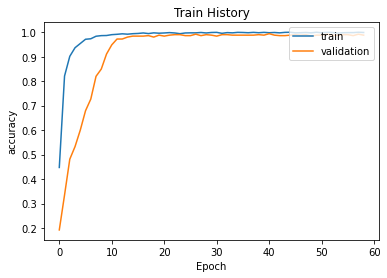

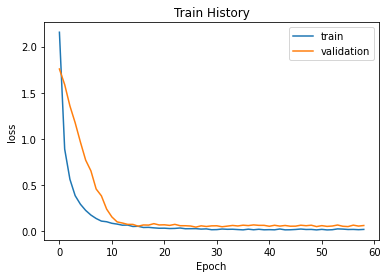

In [10]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel("Epoch")
    plt.legend(['train','validation'],loc='upper right')
    plt.show()

show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

In [11]:
scores = model.evaluate(valid_data)
print('accuracy=',scores[1])

scores = model.evaluate(train_data)
print('accuracy=',scores[1])

16/16 [==============================] - 3s 173ms/step - loss: 0.0522 - accuracy: 0.9901
accuracy= 0.9900990128517151
64/64 [==============================] - 11s 173ms/step - loss: 0.0012 - accuracy: 1.0000
accuracy= 1.0


In [ ]:
model.load_weights(f'CNN_weights_ver7_seed{seed_value}.hdf5')
#model.load_weights('CNN_weights.hdf5')

In [12]:
# predict

# if you forget to reset the test_generator you will get outputs in a weird order
test_data.reset() # need to reset the test_generator before whenever you call the predict_generator

pred = model.predict_generator(test_data,
    verbose=1
)
#pred = model.predict_classes(test_data)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


317/317 [==============================] - 141s 436ms/step


In [13]:
# write predict result to file

#predictions=[]
predicted_class_indices = np.argmax(pred,axis=1) # 沿著行(axis=0)或列(axis=1)查詢最大值的索引號
labels = train_data.class_indices
labels = dict((v,k) for k,v in labels.items())
# 建立代碼標籤與真實標籤(種類名稱)的關係
predictions = [labels[i] for i in predicted_class_indices]

filenames = test_data.filenames
results=pd.DataFrame({"ID":filenames,
                      "Label":predictions})
results.to_csv(f'CNN_ver7_seed{seed_value}.csv',index=False)
#results.to_csv(f'CNN_ver3.csv',index=False)
print(labels)
print(len(predictions))

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}
10142


In [ ]:
# 計算「混淆矩陣」(Confusion Matrix)，顯示訓練集(train set)分類的正確及錯認總和數

scores = model.evaluate(train_data)
print('accuracy=',scores[1])

# Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix

train_data.shuffle = False # 取消 shuffle 以對應正確的 label 和 predict class
# train_data.index_array = None

#train_data.reset()
CM_train_Y_pred = model.predict_generator(train_data, verbose=1)
CM_train_y_pred = np.argmax(CM_train_Y_pred, axis=1)

print('\nConfusion Matrix (sklearn version)')
print(confusion_matrix(train_data.classes, CM_train_y_pred)) # labels = [0, 1, 2, 3, 4, 5]

print('\nConfusion Matrix (pandas version)')
data_train_y_label = np.array(train_data.classes)
print( pd.crosstab(data_train_y_label, CM_train_y_pred, rownames=['Label'], colnames=['Predict']) )

print('\nClassification Report')
target_names = ['1 normal', '2 void', '3 horizontal defect', '4 vertical defect', '5 edge defect', '6 particle']
print(classification_report(train_data.classes, CM_train_y_pred, target_names=target_names))

In [ ]:
# 計算「混淆矩陣」(Confusion Matrix)，顯示驗證集(validation set)分類的正確及錯認總和數

scores = model.evaluate(valid_data)
print('accuracy=',scores[1])

# Confution Matrix and Classification Report

valid_data.shuffle = False # 取消 shuffle 以對應正確的 label 和 predict class
# valid_data.index_array = None

# valid_data.reset()
CM_valid_Y_pred = model.predict_generator(valid_data, verbose=1)
CM_valid_y_pred = np.argmax(CM_valid_Y_pred, axis=1)

print('\nConfusion Matrix (sklearn version)')
print(confusion_matrix(valid_data.classes, CM_valid_y_pred)) # labels = [0, 1, 2, 3, 4, 5]

print('\nConfusion Matrix (pandas version)')
data_valid_y_label = np.array(valid_data.classes)
print( pd.crosstab(data_valid_y_label, CM_valid_y_pred, rownames=['Label'], colnames=['Predict']) )

print('\nClassification Report')
target_names = ['1 normal', '2 void', '3 horizontal defect', '4 vertical defect', '5 edge defect', '6 particle']
print(classification_report(valid_data.classes, CM_valid_y_pred, target_names=target_names))

In [ ]:
def plot_image_label_prediction_wrong(images,labels,prediction,idx,num=10):
    # the parameter "num" decides the amount of images showing
    fig = plt.gcf() # get the current figure
    fig.set_size_inches(12,14) # set the size of the figure
    if num > 20: num=20 # enforce that the maximum amount of the subplot figure is 25
    counter = 0 # record the amount of the image that have been plotted
    for i in range (idx,len(prediction)): # traverse all the prediction of testing data
        #print (i)
        if (labels[i]!=prediction[i]): # if the prediction is wrong (actual image label is not equal prediction)
            # plotting the wrong predicted image
            ax = plt.subplot(4,5,1+counter) # subplot(nrows, ncols, index) # the index of subplot(start from index 1)
            ax.imshow(images[i].reshape(28,28), cmap='binary') # show the image figure of subplot, and represent in gray scale
            # set subplot title to be the actual label and the wrong prediction result of the image 
            title = "label=" +str(labels[i]) + ",predict=" + str(prediction[i]) 
            ax.set_title (title,fontsize=10) # set subplot title and the font size of it
            counter += 1 # "the amount of the image that have been plotted" plus 1
            # ax.set_xticks([]);ax.set_yticks([]) # set that no display the (pixel) scale
        if counter == num: break # if the amount of the image that have been plotted reach the maximum, then stop plotting
    plt.show() # show the whole figure

In [ ]:
model.save(f'CNN_model_ver7_seed{seed_value}.h5')